In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.geometry import sheet_geometry
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 150

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_N_sheet

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/guillaume/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs, reset=True)
geom.update_all(sheet)


In [4]:
specs

{'face': {'prefered_perimeter': 2.0, 'perimeter_elasticity': 0.1},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 0.0001,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'barrier_elasticity': 280}}

In [5]:
specs = {
 'vert': {'barrier_elasticity': 0, 'delta_rho': 0},
    
        }

In [6]:
sheet.update_specs(specs, reset=True)
specs

{'vert': {'barrier_elasticity': 0, 'delta_rho': 0}}

In [7]:
sheet.vert_df["delta_rho"] = sheet.settings["barrier_radius"]-sheet.vert_df["rho"]

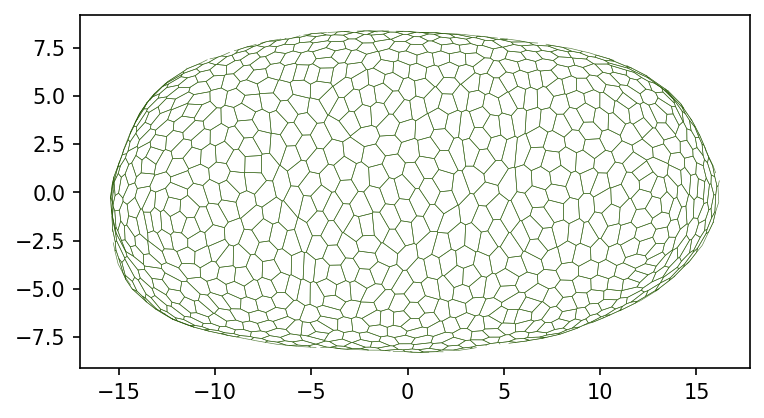

In [8]:
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

fig, ax = draw_half_N_sheet(sheet, None, coords = ["z", "x"])

### Diamètre de la barrière

In [29]:
sheet.settings["barrier_radius"] = 13


In [30]:
lumen_vol_egg= []
theta = np.pi / 3
bes = np.logspace(-3, 0, 10)
br = bes
sheets_obj = {}
diameters = []
middle_dia_s = [] 
aniso_cell_values_d = []
cell_perimeters = []
radius=[]
areas=[]

for i, be in enumerate(bes):
    sheet_copy = sheet.copy()
    sheet_copy.vert_df['barrier_elasticity'] = be
    # add some position noise to avoid being stuck in a local min
    sheet_copy.vert_df[['x', 'y', 'z']] += np.random.normal(0.0, 2e-3, (sheet.Nv, 3))
    print(f"{i+1} / {10}", end=" ")
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    print(res.success)
    lumen_vol_egg.append(sheet_copy.settings['lumen_vol'])
    diameter = 2*(sheet_copy.vert_df["z"].max())
    sheets_obj[be] = sheet_copy
    diameters.append(diameter)
    center_verts =  sheet_copy.vert_df.loc[np.abs(sheet.vert_df["z"]) < 1]
    middle_dia = 2*(center_verts["x"]**2 + center_verts["y"]**2)**(0.5)
    middle_dia_s.append(middle_dia)
    sheet_copy.face_df['anisotropy'] = aniso(sheet_copy, coords = ['x','y','z'])
    center = np.abs(sheet_copy.face_df["z"]) < sheet_copy.face_df["z"].max()*0.75
    area = sheet_copy.face_df.loc[center, 'area'].mean()#area of the cell
    areas.append(area)
    aniso_cell = sheet_copy.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    radius.append(sheet_copy.settings['barrier_radius'])
    print(sheet_copy.settings['barrier_radius'])
    cell_perimeter = sheet_copy.face_df.loc[center, 'perimeter'].mean()
    cell_perimeters.append(cell_perimeter)

lumen_vol_egg = np.array(diameters)
print(diameters)


1 / 10 True
13
2 / 10 True
13
3 / 10 True
13
4 / 10 True
13
5 / 10 True
13
6 / 10 True
13
7 / 10 True
13
8 / 10 True
13
9 / 10 True
13
10 / 10 True
13
[32.822569747609336, 32.81130212036904, 29.636949859468334, 29.030936769745775, 27.540184777453362, 27.14235581921645, 27.018957987838107, 26.37595486775753, 26.086849631640728, 26.059820371958924]


<function matplotlib.pyplot.show(close=None, block=None)>

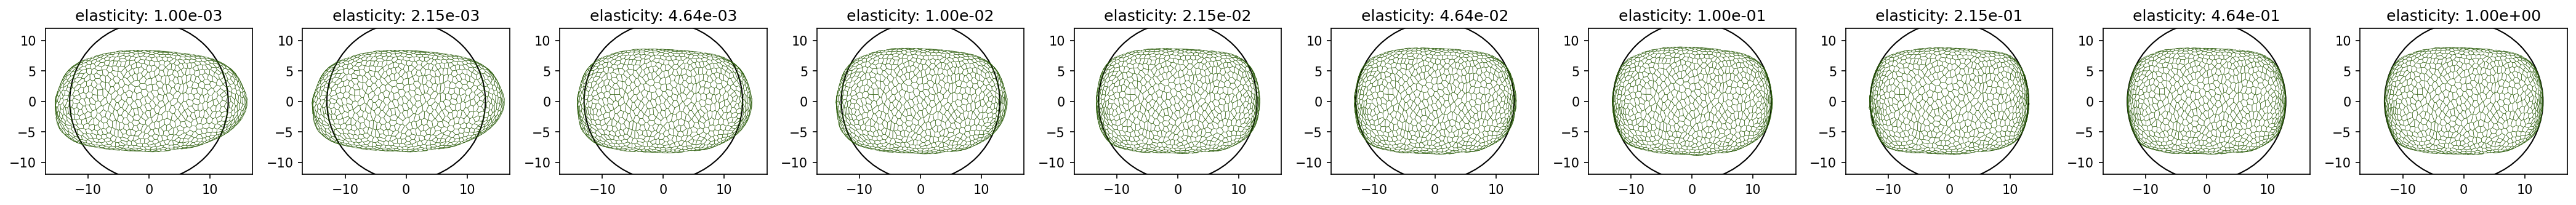

In [31]:
fig, axes = plt.subplots(1, len(sheets_obj), figsize=(28,8))

for i, (be, sheet_copy) in enumerate(sheets_obj.items()):
    #plt.savefig(f'sheet {i+1}.png', transparent=True)
    fig, ax = draw_half_N_sheet(sheet_copy, axes[i], coords = ["z", "x"])
    circle = plt.Circle((0, 0), radius[i], edgecolor='black', facecolor='none')
    ax.add_artist(circle)
    
    ax.set_title(f'elasticity: {be:.2e}')
    ax.set_facecolor('#ffffff')
    ax.set_xlim(-17, 17)
    ax.set_ylim(-12, 12)

    plt.tight_layout()
plt.savefig('../image/barrier_elasticity.png', transparent=True)
plt.show


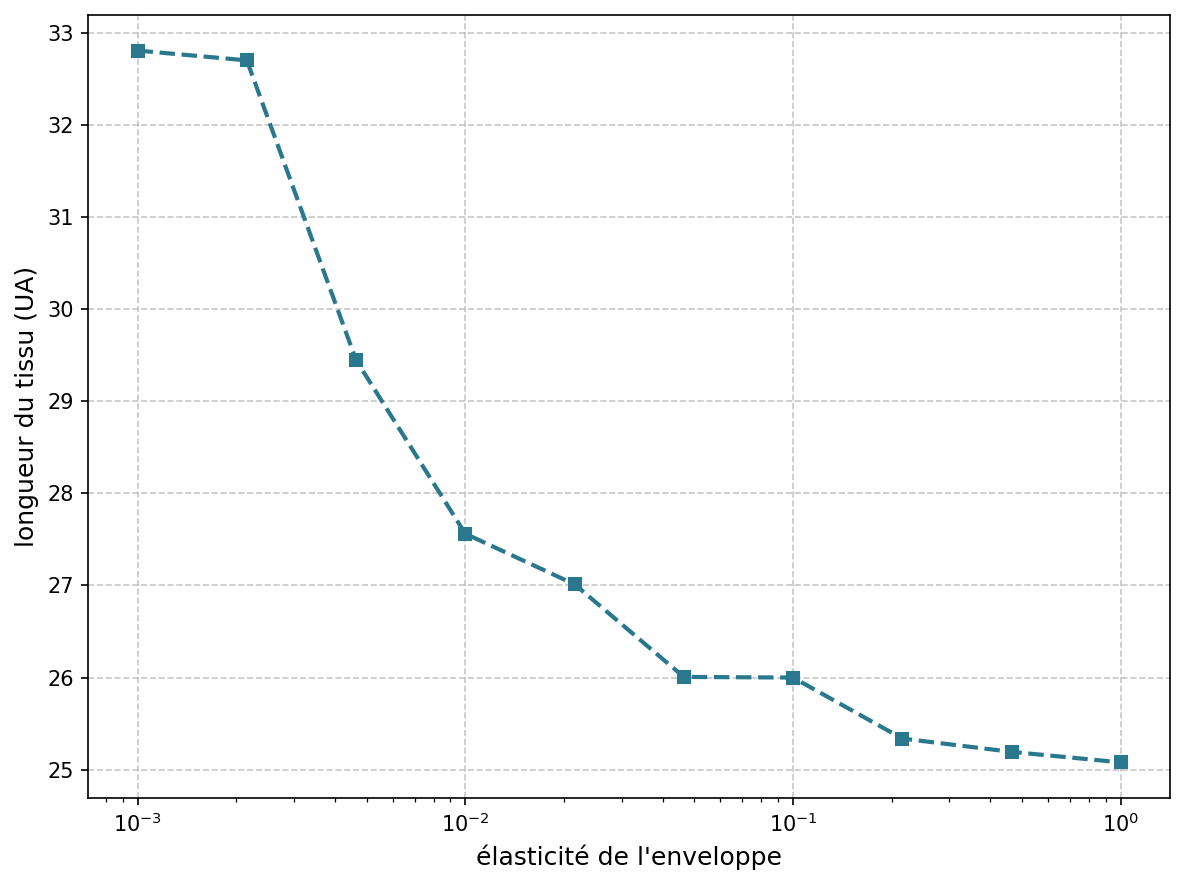

In [21]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(bes, diameters, color=colors[1], marker='s', linestyle='--', linewidth=2)
#axs.set_xscale('log')
axs.set_xlabel("élasticité de l'enveloppe", fontsize=12)
axs.set_ylabel('longueur du tissu (UA)', fontsize=12)
axs.set_xscale("log")
axs.grid(True, linestyle='--', alpha=0.7)
#axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/tissue_length_barrier_elasticity.png', transparent=True)
plt.show()

In [22]:
# Liste pour stocker les moyennes
means = []

# Calculer la moyenne de chaque sous-liste
for sublist in aniso_cell_values_d:
    sublist_mean = np.mean(sublist)
    means.append(sublist_mean)

# Imprimer les moyennes
for mean in means:
    print(mean)

0.23853296951969954
0.2393918681180607
0.26742883049148813
0.29184701231060667
0.29406200942207167
0.30736463475737774
0.30919943802859523
0.3103782440107118
0.30766245942519876
0.31355307079412587


Il y a une différence significative entre les moyennes des deux populations.


IndexError: list index out of range

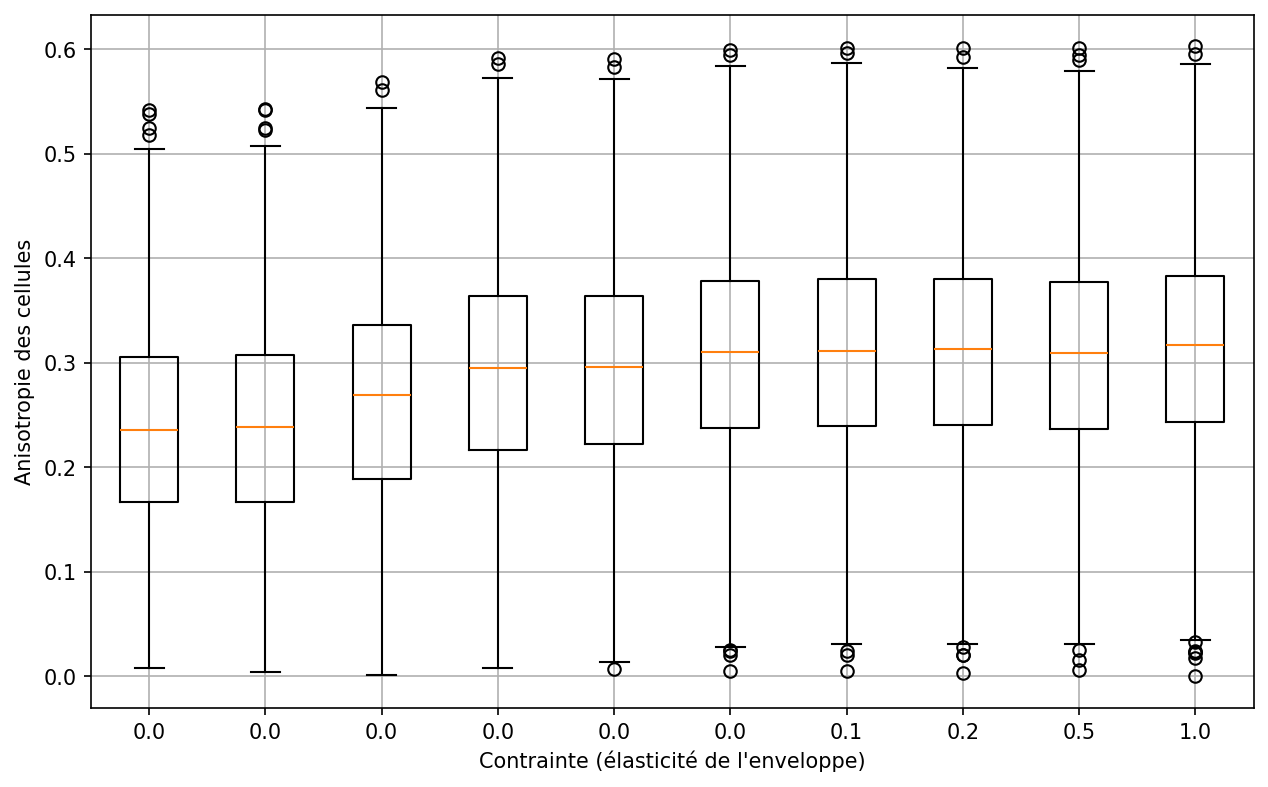

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, ttest_ind

plt.figure(figsize=(10, 6))
plt.boxplot(aniso_cell_values_d)
plt.xlabel("Contrainte (élasticité de l'enveloppe)")
plt.ylabel('Anisotropie des cellules')
plt.xticks(range(1, len(aniso_cell_values_d) + 1), ['{:.1f}'.format(i) for i in bes])
plt.grid(True)

statistic, p_value = ttest_ind(aniso_cell_values_d[0], aniso_cell_values_d[9])

if p_value > 0.05:
    print("Il n'y a pas de différence significative entre les moyennes des deux populations.")
else:
    print("Il y a une différence significative entre les moyennes des deux populations.")
    x_pos1 = 1
    x_pos2 = 10
    y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i+1])) + 0.3
    plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
    if p_value < 0.0001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
    elif p_value < 0.001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
    elif p_value < 0.01:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
    elif p_value < 0.05:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')
    
stat_levene, p_value_levene = levene(*aniso_cell_values_d)


if p_value_levene > 0.05:
    print("Les variances entre les populations sont homogènes.")
    # Appliquer le test d'ANOVA
    statistique, p_value_anova = f_oneway(aniso_cell_values_d[0], aniso_cell_values_d[-1])
    # Interpréter les résultats de l'ANOVA
    if p_value_anova > 0.05:
        print("Il n'y a pas de différence significative entre les moyennes des populations.")
    else:
        print("Il y a une différence significative entre les moyennes des populations.")
        for i in range(len(aniso_cell_values_d) - 1):
            x_pos1 = i+1
            x_pos2 = i+2
            y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i + 1])) + 0.05
            _, p_value_anova = f_oneway(aniso_cell_values_d[i], aniso_cell_values_d[9])

            # Placez le texte des étoiles en fonction de la position des barres
            if p_value_anova < 0.0001:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
            elif p_value_anova < 0.001:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
            elif p_value_anova < 0.01:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
            elif p_value_anova < 0.05:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')

else:
    print("Les variances entre les populations ne sont pas homogènes.")
plt.savefig('../image/aniso_barrier_elasticity.png', transparent=True)
plt.show()


Les variances entre les populations sont homogènes.


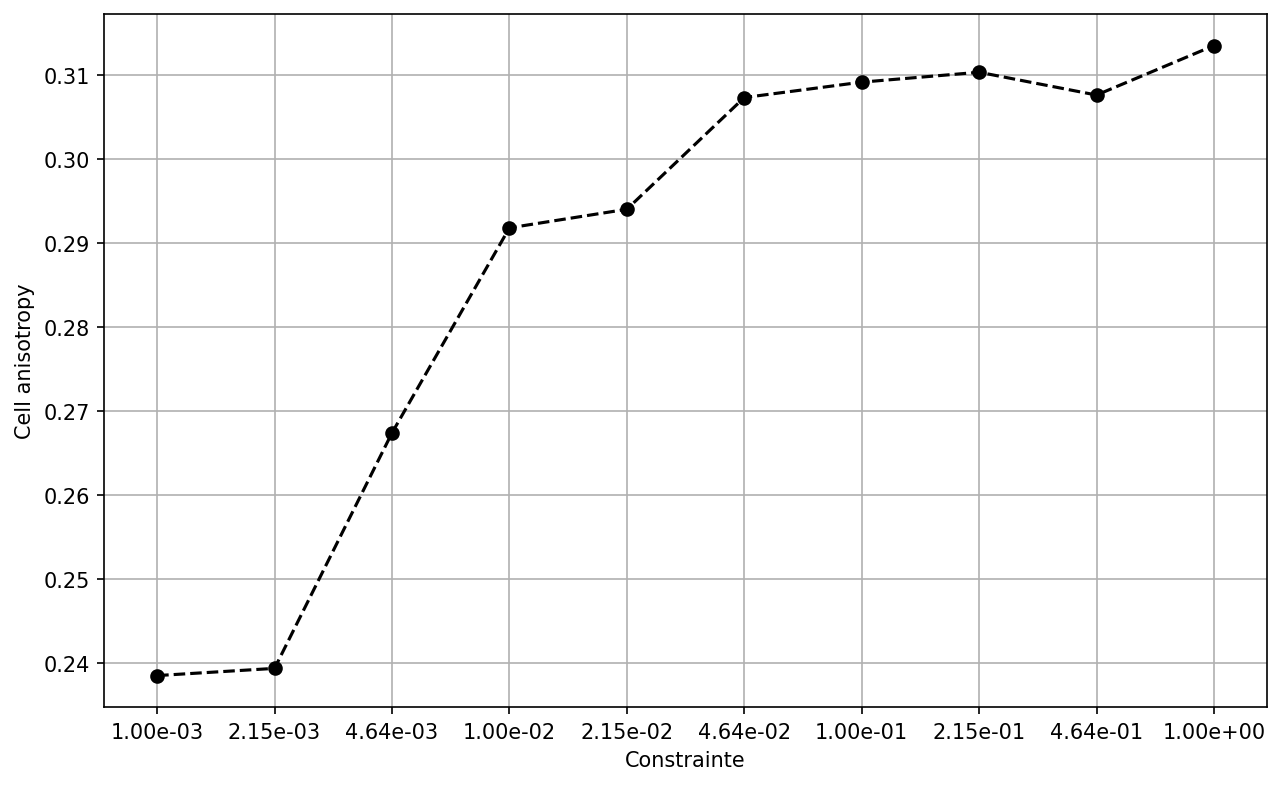

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, ttest_ind
import numpy as np

means = [np.mean(values) for values in aniso_cell_values_d]
x_positions = np.arange(1, len(means) + 1)


plt.figure(figsize=(10, 6))
plt.plot(x_positions, means, marker='o', linestyle='--', color='black')
plt.xlabel("Constrainte")
plt.ylabel('Cell anisotropy')
plt.xticks(x_positions, ['{:.2e}'.format(i) for i in bes])
plt.grid(True)

stat_levene, p_value_levene = levene(*aniso_cell_values_d)


if p_value_levene > 0.05:
    print("Les variances entre les populations sont homogènes.")
    
else:
    print("Les variances entre les populations ne sont pas homogènes.")
plt.savefig('../image/aniso_INS.png', transparent=False)
plt.show()


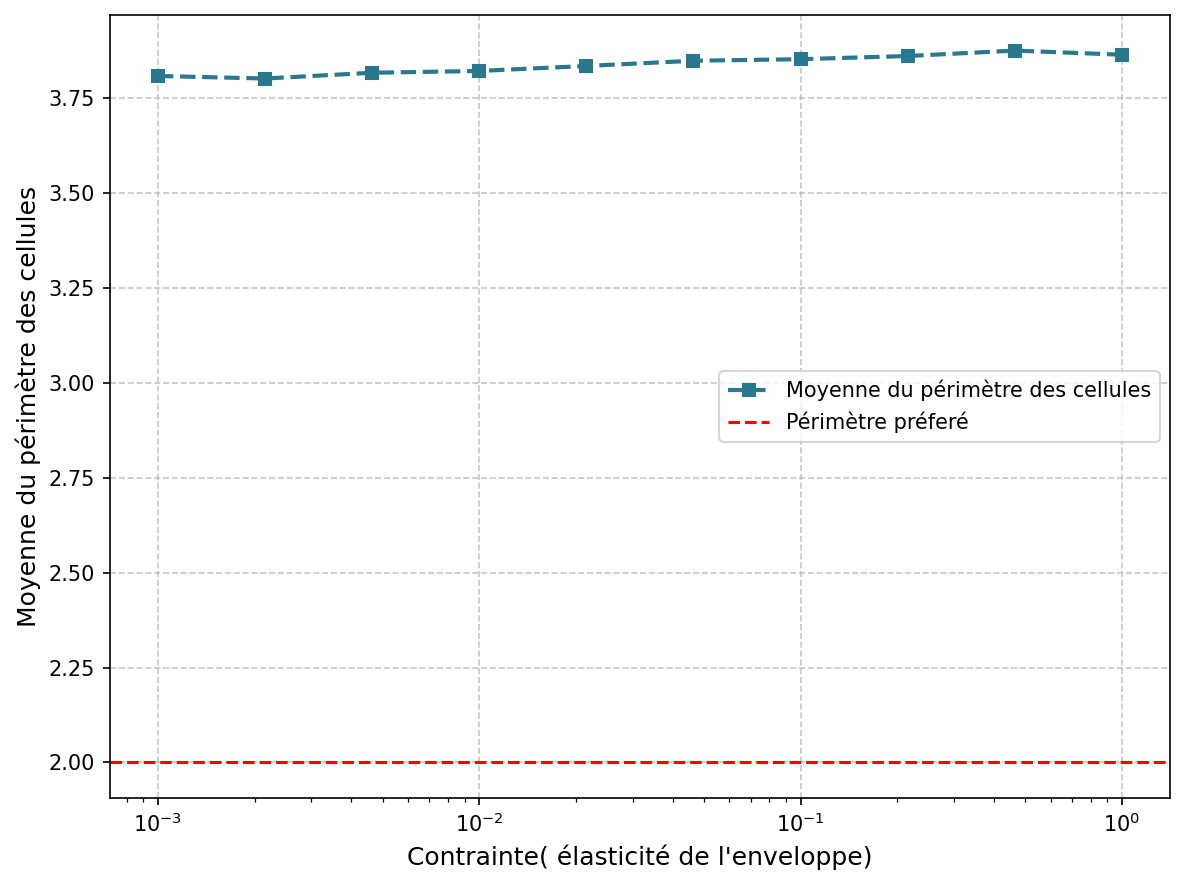

In [27]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(br, cell_perimeters, label='Moyenne du périmètre des cellules', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.axhline(y=2.0, color='r', linestyle='--', label='Périmètre préferé')
axs.set_xlabel("Contrainte( élasticité de l'enveloppe)", fontsize=12)
axs.set_ylabel('Moyenne du périmètre des cellules', fontsize=12)
axs.set_xscale('log')

axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/cell_perimeters_elasticity_barrier.png', transparent=True)
plt.show()

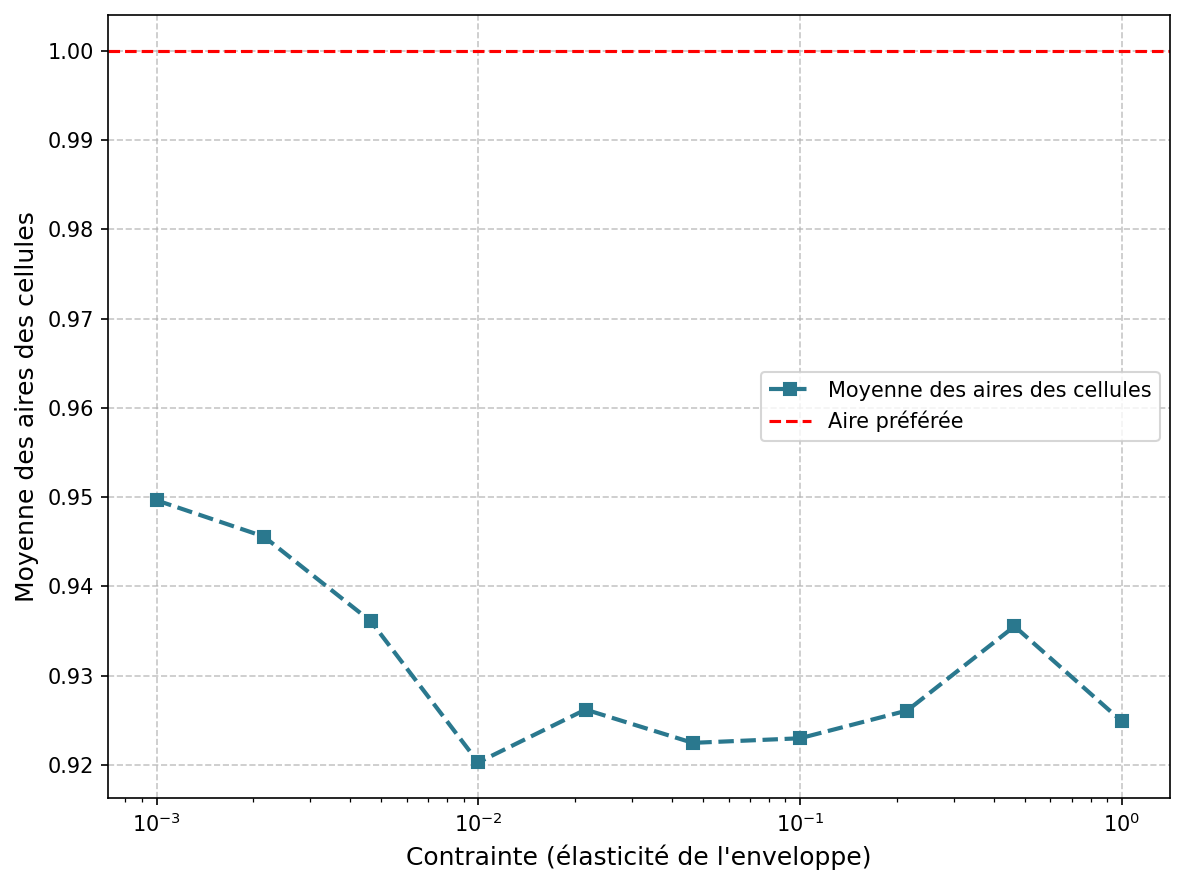

In [28]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(br, areas, label='Moyenne des aires des cellules', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.axhline(y=1, color='r', linestyle='--', label='Aire préférée')
axs.set_xlabel("Contrainte (élasticité de l'enveloppe)", fontsize=12)
axs.set_ylabel('Moyenne des aires des cellules', fontsize=12)
axs.set_xscale('log')


axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/cell_area_elasticity_barrier.png', transparent=False)
plt.show()